In [62]:
import torch
import torch.nn as nn
import numpy as np
import math


#Y_tau = sigma * torch.randn(64,64)
#print(Y_tau)

def gauss_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size):
    Y_tau = Y_0
    for i in range(langevin_step_num):
        noise = torch.randn(image_size, image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (Y_tau / sigma / sigma) + langevin_step_size * noise
        #print(Y_tau)
    return Y_tau

def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, H):
    Y_tau = Y_0
    c = [abs(tau + 1) ** (2 * H) + abs(tau - 1) ** (2 * H) - 2 * abs(tau) ** (2 * H) for tau in range(image_size)]
    cov = np.zeros((image_size, image_size))
    for i in range(image_size):
        for j in range(image_size):
            cov[i][j] = c[abs(i - j)]
    inv_cov = np.linalg.inv(cov) 
    inv_covariance = torch.Tensor(inv_cov)
    for i in range(langevin_step_num):
        noise = torch.randn(image_size, image_size)
        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
        (2 * inv_covariance * Y_tau / sigma / sigma) + langevin_step_size * noise
    return Y_tau


#def gauss_omega_mcmc_simulate(Y_0 ,langevin_step_size ,langevin_step_num ,sigma, image_size, beta):
#    Y_tau = Y_0
#    omegat = range(image_size * image_size) 
#    omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
#    #beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
#    beta_omega = [xx ** beta / image_size / image_size for xx in omega]
#    beta_omega = torch.from_numpy(beta_omega)
#    print(beta_omega)
#    for i in range(langevin_step_num):
#        noise = torch.randn(image_size, image_size)
#        Y_ftau = torch.rfft(Y_tau ,2 ,onesided=False)
#        Y_aftau = torch.sqrt(Y_ftau[:,:,0]*Y_ftau[:,:,0]+Y_ftau[:,:,1]*Y_ftau[:,:,1])
#        #print(Y_aftau.shape)
#        Y_tau = Y_tau - 0.5 * langevin_step_size * langevin_step_size * \
#        (sum(beta_omega) * Y_tau / sigma / sigma) + langevin_step_size * noise
#        print(Y_tau)
#    return Y_tau

#image_size = 128
#Y_0 = sigma * torch.randn(image_size,image_size)
#Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)
#out = torch.rfft(Y_u0,2,onesided=False)
#oo = torch.sqrt(out[:,:,0]*out[:,:,0]+out[:,:,1]*out[:,:,1])
#print(oo.shape)
#print(Y_u0)
#print(oo)

tensor([[0.9804, 1.0188, 0.9457,  ..., 1.2038, 1.0193, 0.8491],
        [1.1373, 1.0620, 1.0216,  ..., 0.8973, 1.0066, 0.9815],
        [1.0121, 1.1358, 0.8629,  ..., 0.8434, 1.1716, 0.6253],
        ...,
        [1.0794, 1.0911, 0.5051,  ..., 0.9364, 0.9508, 0.9563],
        [0.8946, 1.1437, 0.9003,  ..., 0.9316, 1.3118, 1.0625],
        [0.7813, 1.1641, 1.1309,  ..., 0.8880, 1.0231, 0.8087]])


(array([1.85270785e+01, 1.23774540e+01, 2.02150806e-01, 3.82807466e-01,
        8.32459513e-02, 2.80461182e-01, 1.56527948e-01, 4.78415403e-02,
        6.41995619e-02, 8.52308881e-02, 3.31464409e-03, 3.30668819e-02,
        2.33387294e-02, 1.91787790e-02, 1.74966486e-01, 1.92264654e-01,
        7.09516356e-02, 9.44151839e-02, 2.32361021e-01, 1.79388650e-01,
        7.67721309e-02, 2.63996356e-02, 1.62417393e-02, 2.34241203e-02,
        9.76628435e-02, 3.13173882e-02, 1.20536486e-01, 2.32719305e-01,
        1.76044613e-01, 2.24278321e-01, 1.61333504e-01, 1.33621018e-01,
        1.22388345e-01, 7.30993196e-02, 1.02452351e-01, 2.02598571e-01,
        8.44654651e-02, 8.22476159e-03, 5.16545480e-02, 5.47788520e-02,
        6.92063360e-02, 2.78242283e-02, 5.93817311e-05, 3.02541999e-02,
        5.93627686e-02, 1.58227337e-02, 4.44728615e-04, 2.83368185e-02,
        1.03183200e-01, 8.98841521e-02, 2.75539521e-02, 1.59774401e-03,
        1.70311278e-02, 1.55021060e-02, 6.63942198e-02, 6.665836

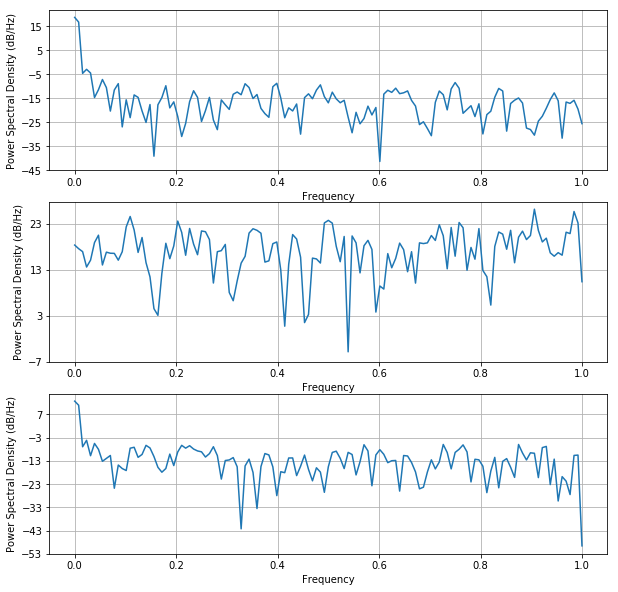

In [100]:
import pylab as plt
langevin_step_size = 0.01
sigma = 10 
langevin_step_num = 200
H = 0.7
#beta = 0.1
image_size = 200
Y_0 = sigma * torch.randn(image_size,image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)
Y_u = 0.1 * sigma * torch.ones(image_size,image_size)


Y_out = gauss_omega_mcmc_simulate(Y_u ,langevin_step_size ,langevin_step_num ,sigma, image_size, H)
print(Y_out)


plt.figure(figsize=(10,10))
plt.subplot(311)
plt.psd(Y_out)
#plt.subplot(212)
plt.subplot(312)
plt.psd(Y_0)
plt.subplot(313)
plt.psd(Y_u0)

(array([2.26120291e-07, 4.44439745e-07, 4.21852376e-07, 3.86785110e-07,
        3.42651026e-07, 2.93423825e-07, 2.43048213e-07, 1.94924735e-07,
        1.51559731e-07, 1.14424071e-07, 8.40120392e-08, 6.00485952e-08,
        4.17695482e-08, 2.81984561e-08, 1.83628625e-08, 1.14221253e-08,
        6.70923106e-09, 3.71090975e-09, 2.01949497e-09, 1.28661327e-09,
        1.19706601e-09, 1.46711172e-09, 1.86009517e-09, 2.20706781e-09,
        2.42092206e-09, 2.49755461e-09, 2.50362306e-09, 2.55490817e-09,
        2.79084137e-09, 3.34967752e-09, 4.34646392e-09, 5.85401139e-09,
        7.88658853e-09, 1.03871232e-08, 1.32204719e-08, 1.61765399e-08,
        1.89866388e-08, 2.13541088e-08, 2.29964483e-08, 2.36922286e-08,
        2.33233537e-08, 2.19028722e-08, 1.95809240e-08, 1.66259881e-08,
        1.33841985e-08, 1.02245717e-08, 7.48118836e-09, 5.40387933e-09,
        4.12671428e-09, 3.65927231e-09, 3.90045711e-09, 4.66986009e-09,
        5.74849918e-09, 6.91980472e-09, 8.00298352e-09, 8.873784

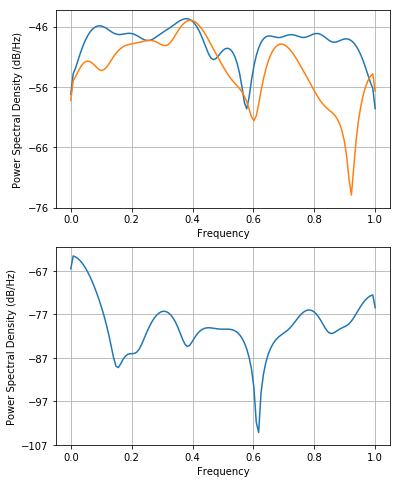

In [64]:
import pylab as plt
langevin_step_size = 0.01
sigma = 0.1  
langevin_step_num = 100
image_size = 32
Y_0 = sigma * torch.randn(image_size,image_size)
Y_u0 = 0.1 * sigma * torch.rand(image_size,image_size)


Y_out = gauss_mcmc_simulate(Y_u0 ,langevin_step_size ,langevin_step_num ,sigma, image_size)
#print(Y_out)


plt.figure(figsize=(6,8))
plt.subplot(211)
plt.psd(Y_0)
#plt.subplot(212)
plt.psd(Y_out)
plt.subplot(212)
plt.psd(Y_u0)

In [4]:
import math
image_size =4
omegat = range(image_size * image_size) 
omega = [math.pi / image_size / image_size * (x - 0.5 * image_size * image_size) for x in omegat]
beta = 0.1
beta_omega = [abs(xx ** beta / image_size / image_size) for xx in omega]
print(omega)
print(sum(beta_omega))
print(1/max(beta_omega))

[-1.5707963267948966, -1.3744467859455345, -1.1780972450961724, -0.9817477042468103, -0.7853981633974483, -0.5890486225480862, -0.39269908169872414, -0.19634954084936207, 0.0, 0.19634954084936207, 0.39269908169872414, 0.5890486225480862, 0.7853981633974483, 0.9817477042468103, 1.1780972450961724, 1.3744467859455345]
0.9069024508903286
15.293539001264099


In [61]:
import numpy as np
image_size = 4
H = 0.5
c = [abs(tau + 1) ** (2 * H) + abs(tau - 1) ** (2 * H) - 2 * abs(tau) ** (2 * H) for tau in range(image_size)]
print(c)
cov = np.zeros((image_size, image_size))
print(cov)
for i in range(image_size):
    for j in range(image_size):
        cov[i][j] = c[abs(i - j)]
print(cov)
inv_cov = np.linalg.inv(cov) 
print(inv_cov)
inv_covariance = torch.from_numpy(inv_cov)
print(inv_covariance)

[2.0, 0.0, 0.0, 0.0]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
[[2. 0. 0. 0.]
 [0. 2. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 2.]]
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.5 0. ]
 [0.  0.  0.  0.5]]
tensor([[0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000]], dtype=torch.float64)
